# Transfer Learnign / fine-tuning challenge

This notebook will explore some data analysis and the usage of transfer learning technic.

The *citrus leaves* [[1]](https://www.tensorflow.org/datasets/catalog/citrus_leaves) dataset from Tensorflow [[2]](https://www.tensorflow.org/datasets) will be used as it is available.

---

## Set up

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import data as tf_data
import tensorflow_datasets as tfds

import keras
from keras import layers, Model

---

## Download dataset

In [ ]:
dataset_train = tfds.load('citrus_leaves', split='train[:80%]', as_supervised=True)
dataset_test = tfds.load('citrus_leaves', split='train[80%:100%]', as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/594 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/citrus_leaves/incomplete.Q7ZEPF_0.1.2/citrus_leaves-train.tfrecord*...:   …

Dataset citrus_leaves downloaded and prepared to /root/tensorflow_datasets/citrus_leaves/0.1.2. Subsequent calls will reuse this data.


Lets take a look at our data (train):

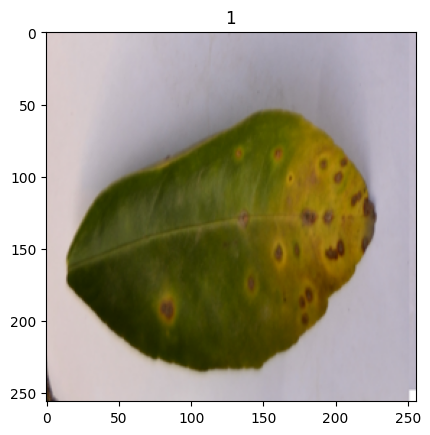

(256, 256, 3)


In [ ]:
image = dataset_train.take(3)
for image, label in tfds.as_numpy(image):
  plt.imshow(image)
  plt.title(label)
  plt.show()
  print(image.shape)

## Is the dataset balanced?

In [ ]:
n_labels = []

for image, label in tfds.as_numpy(dataset_train):
  n_labels.append(label)

Text(0.5, 1.0, 'Histogram plot of classes quantity')

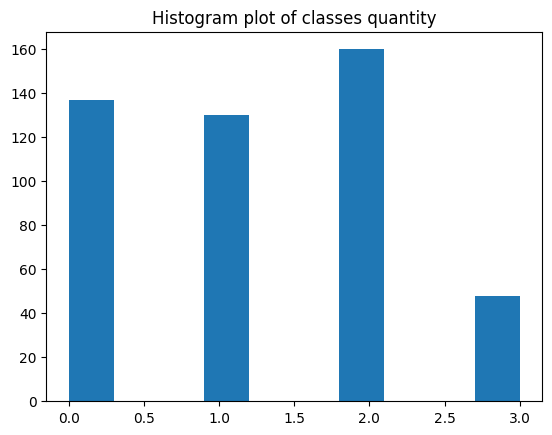

In [ ]:
plt.hist(n_labels)
# plt.grid()
plt.title('Histogram plot of classes quantity')

We can see that our dataset is unbalanced. For the first three ones, we can easily fix by undersampling based on the class number 1.

Also, the third class ('healthy') contains around a third part of the second smallest (1).

Here we have to make a decision. We can:


1.   Use some data augmentation to balance those classes. Basically we could determine a target number "X" ('200' for example) and perform the augmentation on every single class till we have 4*X samples in total;
2.   Downsample the classes 0, 1 and 2 to the same amount of samples at 3;
3.   Just drop the class number 3.

Well, the first option seems to be the more conservative one because we would artificially increase our data which could lead our model to a better performace, but this is not the focus of this notebook. The second option would result in a smaller dataset, which could affect our model convergence even with the transfer learning, due to the small quantity of samples per class (around 50).

So our decision is the third one here. Since we are not actually trying to identify leaf desesases but just use the transfer learning.

** Note that for real applications this decision could be wrong! Your model will always predict a desease because that is all it knows (considering that no further changes were made). Another point is that obtaining healthy leaves is easier than "sick" ones, so we could just take more pictures.







In [ ]:
ds_train = dataset_train.filter(lambda image, label: label==0 or label ==1 or label==2)
ds_test = dataset_test.filter(lambda image, label: label==0 or label ==1 or label==2)

Text(0.5, 1.0, 'Histogram plot of classes quantity after filtering')

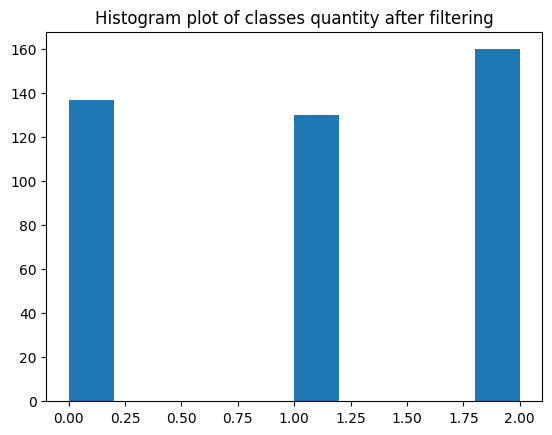

In [ ]:
del n_labels

n_labels = []

for image, label in tfds.as_numpy(ds_train):
  n_labels.append(label)

plt.hist(n_labels)
# plt.grid()
plt.title('Histogram plot of classes quantity after filtering')

Now, lets fetch the dataset for better performance:

In [ ]:
def preprocess(image, label):
  # One-hot encode the labels
  label = tf.keras.utils.to_categorical(label, num_classes=3)
  return image, label

In [ ]:
batch_size = 32


ds_train = ds_train.batch(batch_size)
ds_test = ds_test.batch(batch_size)


ds_train = ds_train.prefetch(tf_data.AUTOTUNE)
ds_test = ds_test.prefetch(tf_data.AUTOTUNE)

# maybe some find weird calling "test" since it is working as validation, so:

ds_valid = ds_test

ds_train = ds_train.map(preprocess)
ds_valid = ds_valid.map(preprocess)


## Model selection:

Now, how can we select a model for this task??

Well, after performing a quick research, a article related to leaves classification with transfer learning came up:
- [A CNN-SVM study based on selected deep features for grapevine leaves classification](https://www.sciencedirect.com/science/article/abs/pii/S0263224121013142?via%3Dihub)

Despite not being "*citrus*" leaves, it is still leaves, so it will be considered valid here.

Two famous architectures were mentioned at the paper and have drawn attention due to their performance related to the accuracy metric: Xception and MobileNetV2.

Xception will be used here due to its parameters quantity and its size both being bigger than the other one (MobileNetV2). Also, we have a small amount of images (around 450), so first lets try the bigger architecture.

---

## Xception

In [ ]:
from keras.applications.xception import Xception
input_shape = (299, 299, 3) # based on https://keras.io/api/applications/xception/

base_model = Xception(
    include_top=False,
    weights="imagenet",
    pooling="avg"
)

base_model.trainable = False

In [ ]:
def model(input_shape=input_shape):
  inputs = keras.Input(shape = input_shape)
  x = layers.Rescaling(1./255)(inputs)
  x = base_model(x)
  x = layers.Dense(256, activation="relu")(x)
  output = layers.Dense(3, activation="softmax")(x)

  return Model(inputs=inputs, outputs=output)

x_model = model()
x_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,386,795 (81.58 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_acc",
        mode = "max",
        patience = 10,
        start_from_epoch = 5
    )
]

In [ ]:
x_model.compile(
    optimizer = keras.optimizers.AdamW(),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy", keras.metrics.CategoricalAccuracy()] # 3 classes
)

In [ ]:
epochs = 30

history = x_model.fit(
    ds_train,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = ds_valid
)

Epoch 1/30
     14/Unknown 29s 679ms/step - accuracy: 0.4757 - categorical_accuracy: 0.4757 - loss: 1.0998

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.4821 - categorical_accuracy: 0.4821 - loss: 1.0879 - val_accuracy: 0.6972 - val_categorical_accuracy: 0.6972 - val_loss: 0.6597
Epoch 2/30


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,categorical_accuracy,loss,val_accuracy,val_categorical_accuracy,val_loss
  current = self.get_monitor_value(logs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.8456 - categorical_accuracy: 0.8456 - loss: 0.4301 - val_accuracy: 0.8257 - val_categorical_accuracy: 0.8257 - val_loss: 0.4121
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.8476 - categorical_accuracy: 0.8476 - loss: 0.3389 - val_accuracy: 0.8532 - val_categorical_accuracy: 0.8532 - val_loss: 0.3800
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.9249 - categorical_accuracy: 0.9249 - loss: 0.2458 - val_accuracy: 0.8165 - val_categorical_accuracy: 0.8165 - val_loss: 0.3740
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.9000 - categorical_accuracy: 0.9000 - loss: 0.2180 - val_accuracy: 0.8624 - val_categorical_accuracy: 0.8624 - val_loss: 0.3673
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.9678 - categorical_accuracy: 0.9678 - loss: 0.1462 - val_accuracy: 0.8349 - val_categorical_accuracy: 0.8349 - val_loss: 0.3743
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 

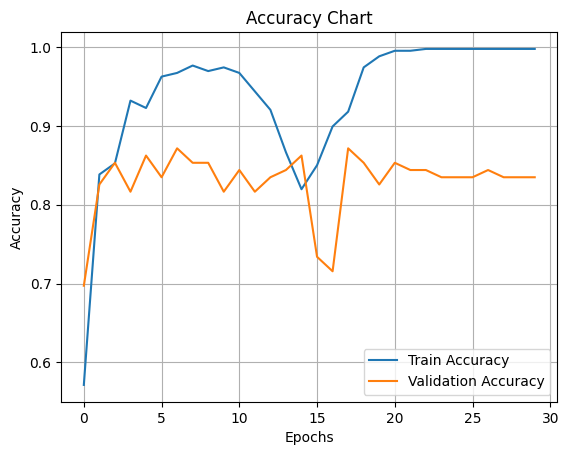

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.title("Accuracy Chart")
plt.show()

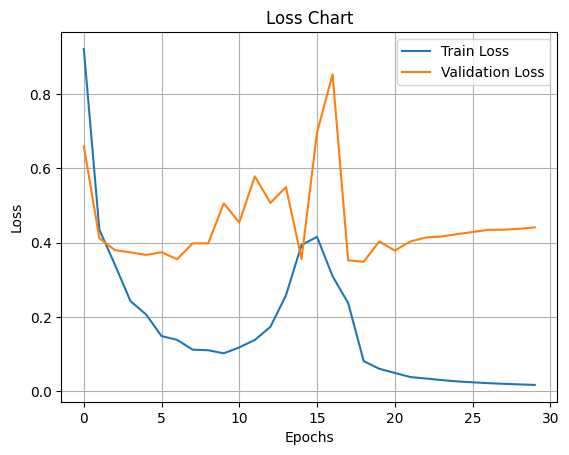

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Validation Loss"])
plt.title("Loss Chart")
plt.show()

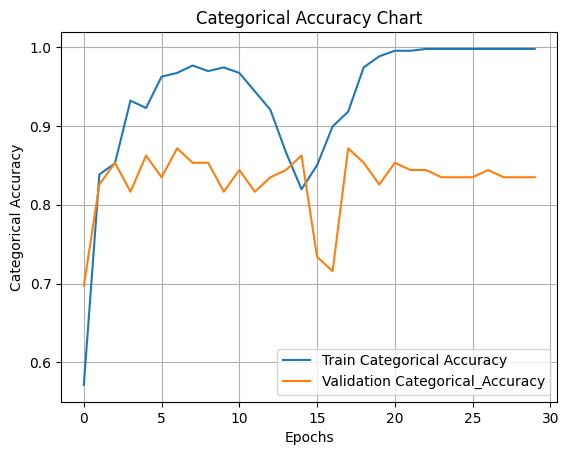

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Categorical Accuracy")
plt.legend(["Train Categorical Accuracy", "Validation Categorical Accuracy"])
plt.title("Categorical Accuracy Chart")
plt.show()

---

## Conclusion

Since we have achieved above 80% accuracy and categorical accuracy, MobileNetV2 will not be used.

To achieve better results we could use some data augmentation, insert more Dense Layers after the base model or increase their number of neurons.

Looking at the graphics, with the actual architecture, training for more epochs will not result in better performance necessarily since all of them seems to have stabilized around 25 epochs.

Finally, for this challenge purposes, the coding ends here!